<a href="https://colab.research.google.com/github/m-wessler/gefs-ai-ml/blob/main/Machine_Learning_Regression_Methodology_Comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from datetime import datetime

from sklearn.model_selection import train_test_split

In [195]:
# Configuration
STATION_ID = "KSLC" # Change as needed
CSV_PATH = "/content/KBOI_2000_2009_f024.csv" # Path to your data (ensure this exists)
TARGET_VARIABLE = "tmax_obs"
PREDICTOR = "tmax_2m" # Minimal: just use tmax_2m as predictor (change as needed)

EXCLUDE_VARS = [] #["tmp_2m", "tmax_2m"]

AFILE_VARS = ["pres_msl", "pres_sfc", "hgt_pres", "tmp_2m", "tmp_pres", "tmin_2m", "tmax_2m", "ugrd_hgt",
              "ugrd_pres", "vgrd_hgt", "vgrd_pres", "dswrf_sfc", "dlwrf_sfc", "uswrf_sfc", "ulwrf_sfc",
              "lhtfl_sfc", "shtfl_sfc", "soil_bgrnd", "tcdc_eatm"]

In [198]:
# Load data
df = pd.read_csv(CSV_PATH)

df['valid_datetime'] = df['valid_datetime'].astype('datetime64[ns]')
df['doy'] = df['valid_datetime'].dt.dayofyear

keep_cols = [c for c in df.columns if (any(var in c for var in AFILE_VARS)
                and not any(var in c for var in EXCLUDE_VARS))]

[keep_cols.append(c) for c in ["valid_datetime", "doy", TARGET_VARIABLE]]

df = df[keep_cols]
df.set_index("valid_datetime", inplace=True)

print(df.columns)

df.dropna(how='any', inplace=True)
X = df.drop(columns=[TARGET_VARIABLE])
y = df[TARGET_VARIABLE]

# First split: train+val and test (e.g., 70% train+val, 30% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: train and val (e.g., from 70% train+val, take 70% train, 30% val ⇒ 49% train, 21% val overall)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

df

Index(['pres_msl', 'pres_sfc', 'hgt_pres_925', 'hgt_pres_850', 'hgt_pres_700',
       'tmp_2m', 'tmp_pres_925', 'tmp_pres_850', 'tmp_pres_700', 'tmax_2m',
       'tmin_2m', 'ugrd_hgt', 'ugrd_pres_925', 'ugrd_pres_850',
       'ugrd_pres_700', 'vgrd_hgt', 'vgrd_pres_925', 'vgrd_pres_850',
       'vgrd_pres_700', 'dswrf_sfc', 'dlwrf_sfc', 'uswrf_sfc', 'ulwrf_sfc',
       'lhtfl_sfc', 'shtfl_sfc', 'tcdc_eatm', 'doy', 'tmax_obs'],
      dtype='object')


,pres_msl,pres_sfc,hgt_pres_925,hgt_pres_850,hgt_pres_700,tmp_2m,tmp_pres_925,tmp_pres_850,tmp_pres_700,tmax_2m,...,vgrd_pres_700,dswrf_sfc,dlwrf_sfc,uswrf_sfc,ulwrf_sfc,lhtfl_sfc,shtfl_sfc,tcdc_eatm,doy,tmax_obs
valid_datetime,,,,,,,,,,,,,,,,,,,,,
2000-01-02,101353.72750,90042.86042,736.00358,1406.96538,2923.58308,-2.12,-0.84,-2.90,-10.71,-1.38,...,1.22198,180.0,267.33783,68.0,309.75751,20.26607,14.70149,100.0,2,-2.8
2000-01-02,101428.78750,90115.99167,742.41585,1414.23100,2928.55100,-1.99,-0.66,-2.68,-11.62,-0.85,...,-2.89642,150.0,282.00000,57.0,311.41245,17.11140,12.70422,100.0,2,-2.8
2000-01-02,101387.39167,90120.23542,741.93842,1415.94334,2934.75867,-1.13,0.40,-2.16,-10.65,-0.05,...,0.78917,160.0,272.00000,63.0,311.82449,18.96084,4.46164,100.0,2,-2.8
2000-01-02,101390.71250,90102.75625,740.91771,1413.47867,2929.51125,-1.44,-0.11,-2.79,-10.94,-0.42,...,1.41911,175.0,270.00000,68.0,313.00769,19.55219,9.50864,100.0,2,-2.8
2000-01-02,101416.45833,90105.87292,741.47644,1413.22013,2928.80058,-1.95,-0.61,-2.82,-11.25,-0.84,...,-0.39066,170.0,274.00000,63.0,310.67816,19.77952,10.81091,100.0,2,-2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-01,102733.93750,91330.25000,848.72220,1520.27730,3044.71970,-0.62,0.03,-3.86,-8.38,0.43,...,3.71870,110.0,297.00000,37.0,312.62650,30.17330,-1.45510,100.0,1,3.3
2010-01-01,102908.15620,91474.56250,861.47270,1532.36490,3055.44950,-0.83,-0.26,-3.64,-8.38,0.39,...,2.03420,160.0,285.00000,55.0,314.45300,32.72990,9.42930,100.0,1,3.3
2010-01-01,102844.85160,91408.64840,855.70480,1525.85940,3049.08720,-1.11,-0.51,-4.17,-7.88,0.18,...,3.03200,150.0,289.00000,50.0,313.71710,35.78290,7.40040,97.0,1,3.3


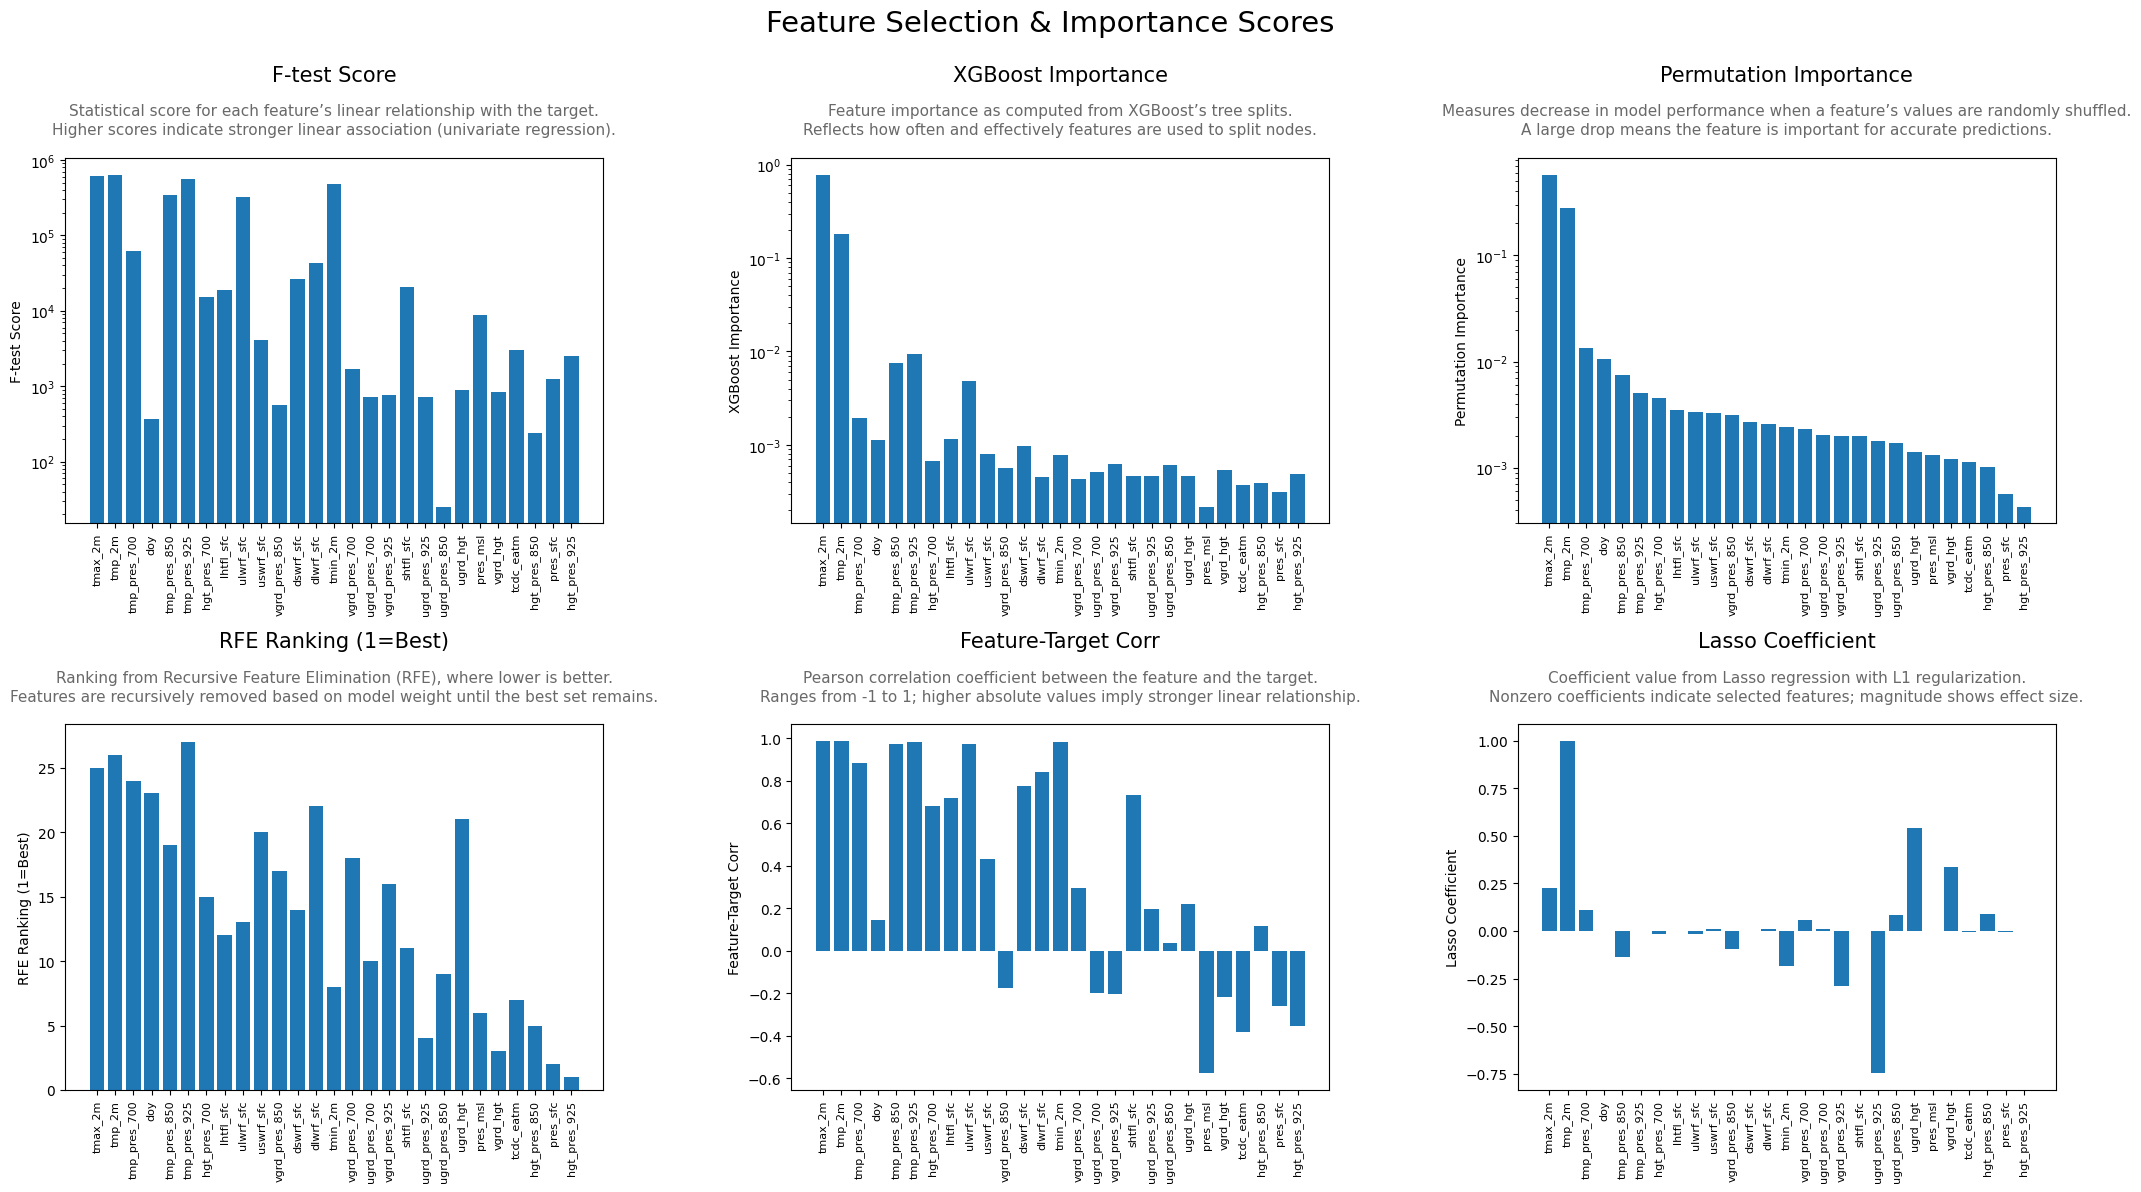

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from sklearn.linear_model import Lasso
from sklearn.inspection import permutation_importance
import xgboost as xgb

# Fit XGBoost
model = xgb.XGBRegressor(random_state=42)
model.fit(X, y)

# 1. Univariate F-test
selector = SelectKBest(f_regression, k='all').fit(X, y)
f_scores = selector.scores_

# 2. XGBoost Feature Importance
xgb_importance = model.feature_importances_

# 3. Permutation Importance
perm = permutation_importance(model, X, y, n_repeats=10, random_state=42)
perm_importance = perm.importances_mean

# 4. RFE Ranking
rfe = RFE(model, n_features_to_select=1)
rfe.fit(X, y)
rfe_ranking = rfe.ranking_

# 5. Feature-Target Correlation
corr = np.array([np.corrcoef(X[col], y)[0,1] for col in X.columns])

# 6. Lasso Coefficients
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X, y)
lasso_coef = lasso.coef_

# Create a DataFrame for plotting
feature_data = pd.DataFrame({
    'F-test': f_scores,
    'XGBoost Importance': xgb_importance,
    'Permutation Importance': perm_importance,
    'RFE Ranking': rfe_ranking,
    'Feature-Target Corr': corr,
    'Lasso Coef': lasso_coef
}, index=X.columns)

# Sort features by XGBoost importance (descending)
feature_data_sorted = feature_data.sort_values('XGBoost Importance', ascending=False)

fig, axes = plt.subplots(2, 3, figsize=(22, 12))  # Slightly taller figure
fig.tight_layout(pad=6.0, rect=[0, 0, 1, 0.94])   # More padding + tighter top

plot_info = [
    ('F-test', 'F-test Score'),
    ('XGBoost Importance', 'XGBoost Importance'),
    ('Permutation Importance', 'Permutation Importance'),
    ('RFE Ranking', 'RFE Ranking (1=Best)'),
    ('Feature-Target Corr', 'Feature-Target Corr'),
    ('Lasso Coef', 'Lasso Coefficient')
]

metric_desc = {
    'F-test': (
        "Statistical score for each feature’s linear relationship with the target.\n"
        "Higher scores indicate stronger linear association (univariate regression)."
    ),
    'XGBoost Importance': (
        "Feature importance as computed from XGBoost’s tree splits.\n"
        "Reflects how often and effectively features are used to split nodes."
    ),
    'Permutation Importance': (
        "Measures decrease in model performance when a feature’s values are randomly shuffled.\n"
        "A large drop means the feature is important for accurate predictions."
    ),
    'RFE Ranking': (
        "Ranking from Recursive Feature Elimination (RFE), where lower is better.\n"
        "Features are recursively removed based on model weight until the best set remains."
    ),
    'Feature-Target Corr': (
        "Pearson correlation coefficient between the feature and the target.\n"
        "Ranges from -1 to 1; higher absolute values imply stronger linear relationship."
    ),
    'Lasso Coef': (
        "Coefficient value from Lasso regression with L1 regularization.\n"
        "Nonzero coefficients indicate selected features; magnitude shows effect size."
    )
}

for ax, (col, title) in zip(axes.flatten(), plot_info):
    vals = feature_data_sorted[col]
    if col == 'RFE Ranking':
        vals = vals[::-1]
    ax.bar(feature_data_sorted.index, vals)
    ax.set_title(title+"\n\n", fontsize=15, pad=22)  # More space above bars
    # Add the detailed description below the title, with generous y-position
    ax.text(
        0.5, 1.15,
        metric_desc[col],
        fontsize=11,
        color='dimgray',
        ha='center',
        va='top',
        linespacing=1.35,
        wrap=True,
        transform=ax.transAxes
    )
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.set_ylabel(title)
    if len(feature_data_sorted.index) > 30:
        step = len(feature_data_sorted.index) // 30
        for label in ax.get_xticklabels():
            label.set_visible(False)
        for i, label in enumerate(ax.get_xticklabels()):
            if i % step == 0:
                label.set_visible(True)
    if col in ['F-test', 'XGBoost Importance', 'Permutation Importance']:
        ax.set_yscale('log')

plt.suptitle('Feature Selection & Importance Scores', fontsize=21, y=0.99)
plt.subplots_adjust(hspace=0.55, wspace=0.35)  # More vertical and horizontal space
plt.show()

Add  tmp_pres_925                   with p-value 0.000000
Add  tmp_2m                         with p-value 0.000000
Add  uswrf_sfc                      with p-value 0.000000
Drop tmp_pres_925                   with p-value 0.969438
Add  ugrd_pres_925                  with p-value 0.000000
Add  lhtfl_sfc                      with p-value 0.000000
Add  tmin_2m                        with p-value 0.000000
Add  dlwrf_sfc                      with p-value 0.000000
Add  ugrd_hgt                       with p-value 0.000000
Add  ugrd_pres_850                  with p-value 0.000000
Add  vgrd_pres_700                  with p-value 0.000000
Add  doy                            with p-value 0.000000
Add  ugrd_pres_700                  with p-value 0.000000
Add  ulwrf_sfc                      with p-value 0.000000
Add  tmp_pres_850                   with p-value 0.000000
Add  tmp_pres_700                   with p-value 0.000000
Add  vgrd_pres_850                  with p-value 0.000000
Add  tcdc_eatm

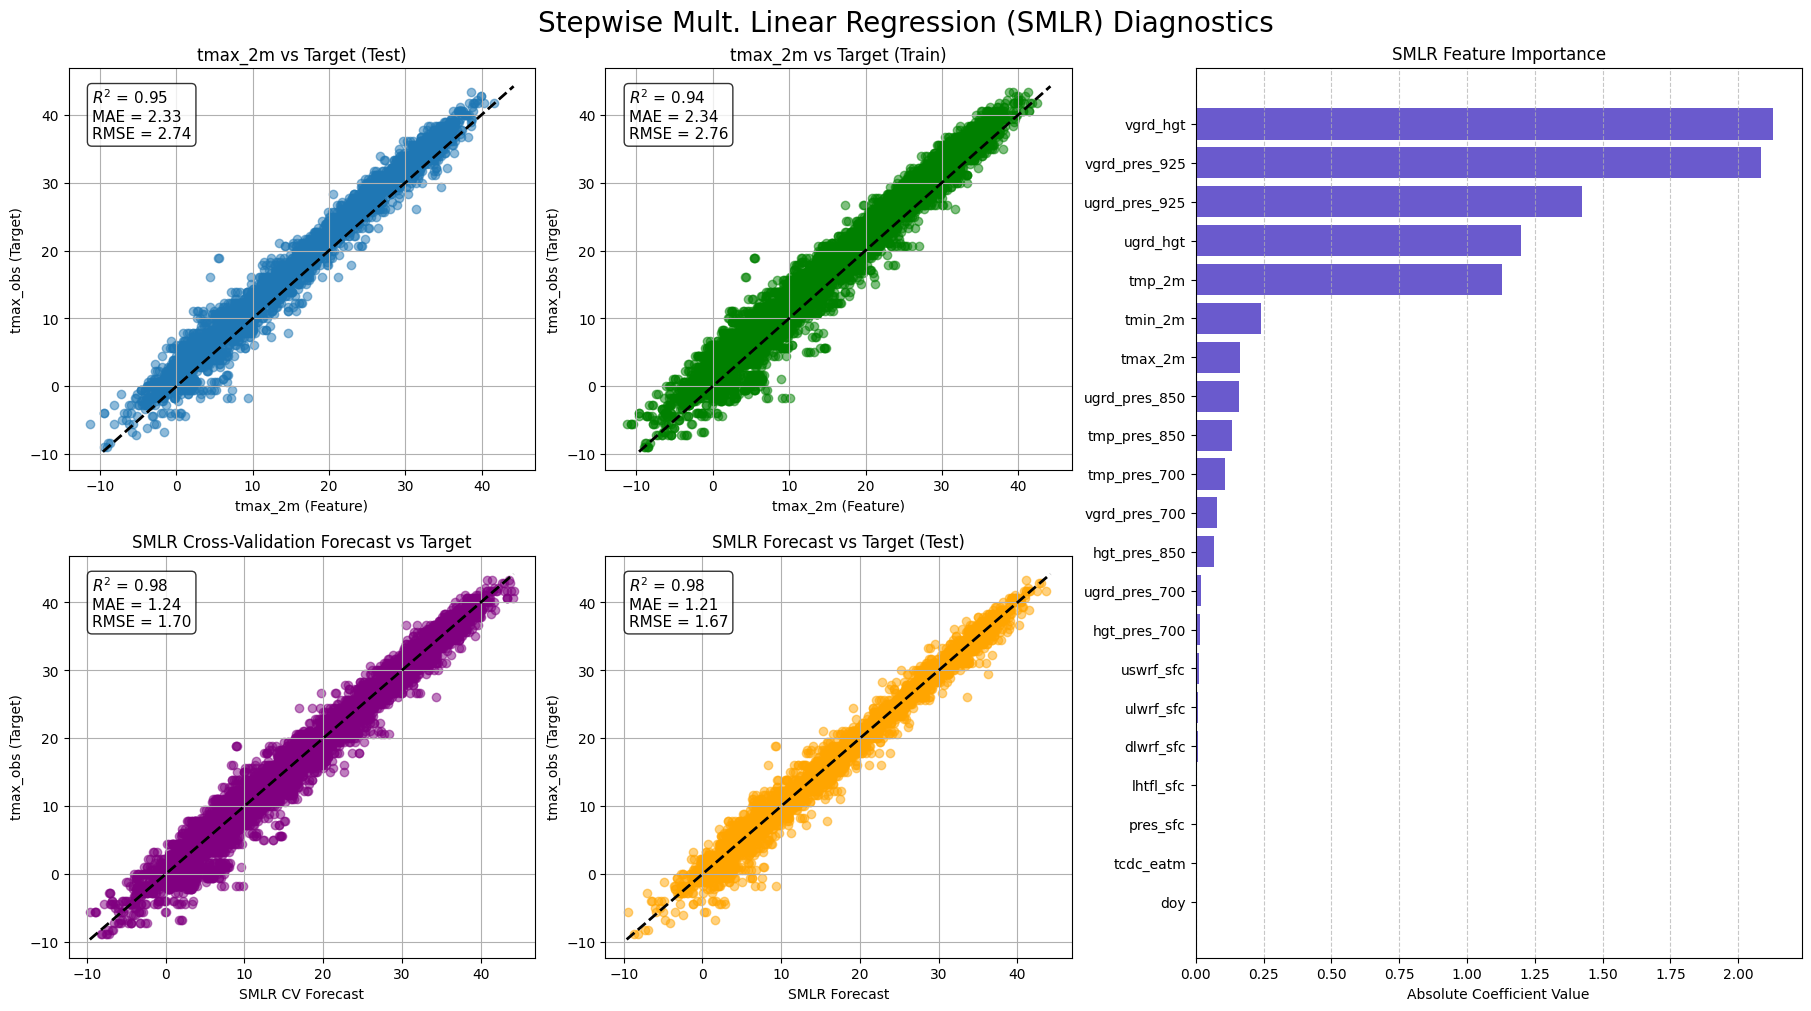

In [191]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assume X_train, X_val, X_test, y_train, y_val, y_test are already defined

def stepwise_selection(X, y,
                      initial_features=[],
                      threshold_in=0.01,
                      threshold_out=0.05,
                      verbose=False):
    included = list(initial_features)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f'Add  {best_feature:30} with p-value {best_pval:.6f}')
        # backward step
        if included:
            model = sm.OLS(y, sm.add_constant(X[included])).fit()
            # use all coefs except intercept
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                changed = True
                if verbose:
                    print(f'Drop {worst_feature:30} with p-value {worst_pval:.6f}')
        if not changed:
            break
    return included

# If X_train, X_val, X_test are numpy arrays, convert to DataFrame for feature names
if not isinstance(X_train, pd.DataFrame):
    feature_names = [f"X{i}" for i in range(X_train.shape[1])]
    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_val = pd.DataFrame(X_val, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names)
else:
    feature_names = X_train.columns

selected_features = stepwise_selection(X_train, y_train, verbose=True)
print("Selected features:", selected_features)

# Train model with selected features
reg = LinearRegression()
reg.fit(X_train[selected_features], y_train)

# Cross-validation predictions for diagnostics
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_true = []
cv_pred = []
for train_index, test_index in kf.split(X_train[selected_features]):
    X_tr, X_te = X_train[selected_features].iloc[train_index], X_train[selected_features].iloc[test_index]
    y_tr = y_train.iloc[train_index] if hasattr(y_train, "iloc") else y_train[train_index]
    y_te = y_train.iloc[test_index] if hasattr(y_train, "iloc") else y_train[test_index]
    reg_cv = LinearRegression()
    reg_cv.fit(X_tr, y_tr)
    y_te_pred = reg_cv.predict(X_te)
    cv_true.append(y_te)
    cv_pred.append(y_te_pred)
cv_true = np.concatenate(cv_true)
cv_pred = np.concatenate(cv_pred)
cv_r2 = r2_score(cv_true, cv_pred)
cv_mae = mean_absolute_error(cv_true, cv_pred)
cv_rmse = np.sqrt(mean_squared_error(cv_true, cv_pred))
print(f"Cross-validated R2: {cv_r2:.4f}")

def print_metrics(name, y_true, y_pred):
    print(f"{name} R2:   {r2_score(y_true, y_pred):.4f}")
    print(f"{name} MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")

# Validation metrics
y_val_pred = reg.predict(X_val[selected_features])
print_metrics("Validation", y_val, y_val_pred)

# Test metrics
y_test_pred = reg.predict(X_test[selected_features])
print_metrics("Test", y_test, y_test_pred)

# For plotting
min_val = min(np.min(y_test), np.min(y_test_pred), np.min(cv_true), np.min(cv_pred))
max_val = max(np.max(y_test), np.max(y_test_pred), np.max(cv_true), np.max(cv_pred))

fig = plt.figure(figsize=(18, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1.3], height_ratios=[1, 1], figure=fig)

axes = {}
axes['tl'] = fig.add_subplot(gs[0, 0])
axes['tm'] = fig.add_subplot(gs[0, 1])
axes['bl'] = fig.add_subplot(gs[1, 0])
axes['bm'] = fig.add_subplot(gs[1, 1])
ax_feat = fig.add_subplot(gs[:, 2])

# 1. Top left: Test set tmax_2m vs tmax_obs
axes['tl'].scatter(X_test['tmax_2m'], y_test, alpha=0.5)
axes['tl'].set_xlabel('tmax_2m (Feature)')
axes['tl'].set_ylabel('tmax_obs (Target)')
axes['tl'].set_title('tmax_2m vs Target (Test)')
axes['tl'].grid(True)
axes['tl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_left = r2_score(y_test, X_test['tmax_2m'])
mae_left = mean_absolute_error(y_test, X_test['tmax_2m'])
rmse_left = np.sqrt(mean_squared_error(y_test, X_test['tmax_2m']))
metrics_text_left = f"$R^2$ = {r2_left:.2f}\nMAE = {mae_left:.2f}\nRMSE = {rmse_left:.2f}"
axes['tl'].annotate(metrics_text_left, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Top middle: Train set tmax_2m vs tmax_obs
axes['tm'].scatter(X_train['tmax_2m'], y_train, alpha=0.5, color='green')
axes['tm'].set_xlabel('tmax_2m (Feature)')
axes['tm'].set_ylabel('tmax_obs (Target)')
axes['tm'].set_title('tmax_2m vs Target (Train)')
axes['tm'].grid(True)
axes['tm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_train = r2_score(y_train, X_train['tmax_2m'])
mae_train = mean_absolute_error(y_train, X_train['tmax_2m'])
rmse_train = np.sqrt(mean_squared_error(y_train, X_train['tmax_2m']))
metrics_text_train = f"$R^2$ = {r2_train:.2f}\nMAE = {mae_train:.2f}\nRMSE = {rmse_train:.2f}"
axes['tm'].annotate(metrics_text_train, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Bottom left: SMLR CV Forecast vs tmax_obs (cross-validation)
axes['bl'].scatter(cv_pred, cv_true, alpha=0.5, color='purple')
axes['bl'].set_xlabel('SMLR CV Forecast')
axes['bl'].set_ylabel('tmax_obs (Target)')
axes['bl'].set_title('SMLR Cross-Validation Forecast vs Target')
axes['bl'].grid(True)
axes['bl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
metrics_text_cv = f"$R^2$ = {cv_r2:.2f}\nMAE = {cv_mae:.2f}\nRMSE = {cv_rmse:.2f}"
axes['bl'].annotate(metrics_text_cv, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Bottom middle: SMLR Forecast vs tmax_obs (Test set)
axes['bm'].scatter(y_test_pred, y_test, alpha=0.5, color='orange')
axes['bm'].set_xlabel('SMLR Forecast')
axes['bm'].set_ylabel('tmax_obs (Target)')
axes['bm'].set_title('SMLR Forecast vs Target (Test)')
axes['bm'].grid(True)
axes['bm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
metrics_text_test = f"$R^2$ = {r2_test:.2f}\nMAE = {mae_test:.2f}\nRMSE = {rmse_test:.2f}"
axes['bm'].annotate(metrics_text_test, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Feature importance (right): Absolute value of coefficients
coef_importance = np.abs(reg.coef_)
sorted_idx = np.argsort(coef_importance)
ax_feat.barh(np.array(selected_features)[sorted_idx], coef_importance[sorted_idx], color='slateblue')
ax_feat.set_xlabel('Absolute Coefficient Value')
ax_feat.set_title('SMLR Feature Importance')
ax_feat.grid(axis='x', linestyle='--', alpha=0.7)

fig.suptitle("Stepwise Mult. Linear Regression (SMLR) Diagnostics", fontsize=20)
plt.show()

Best alpha (regularization strength): 5.280149614811924
Cross-validated R2: 0.9720
Validation R2:   0.9713
Validation MAE:  1.4118
Validation RMSE: 1.9522
Test R2:   0.9735
Test MAE:  1.3973
Test RMSE: 1.9109


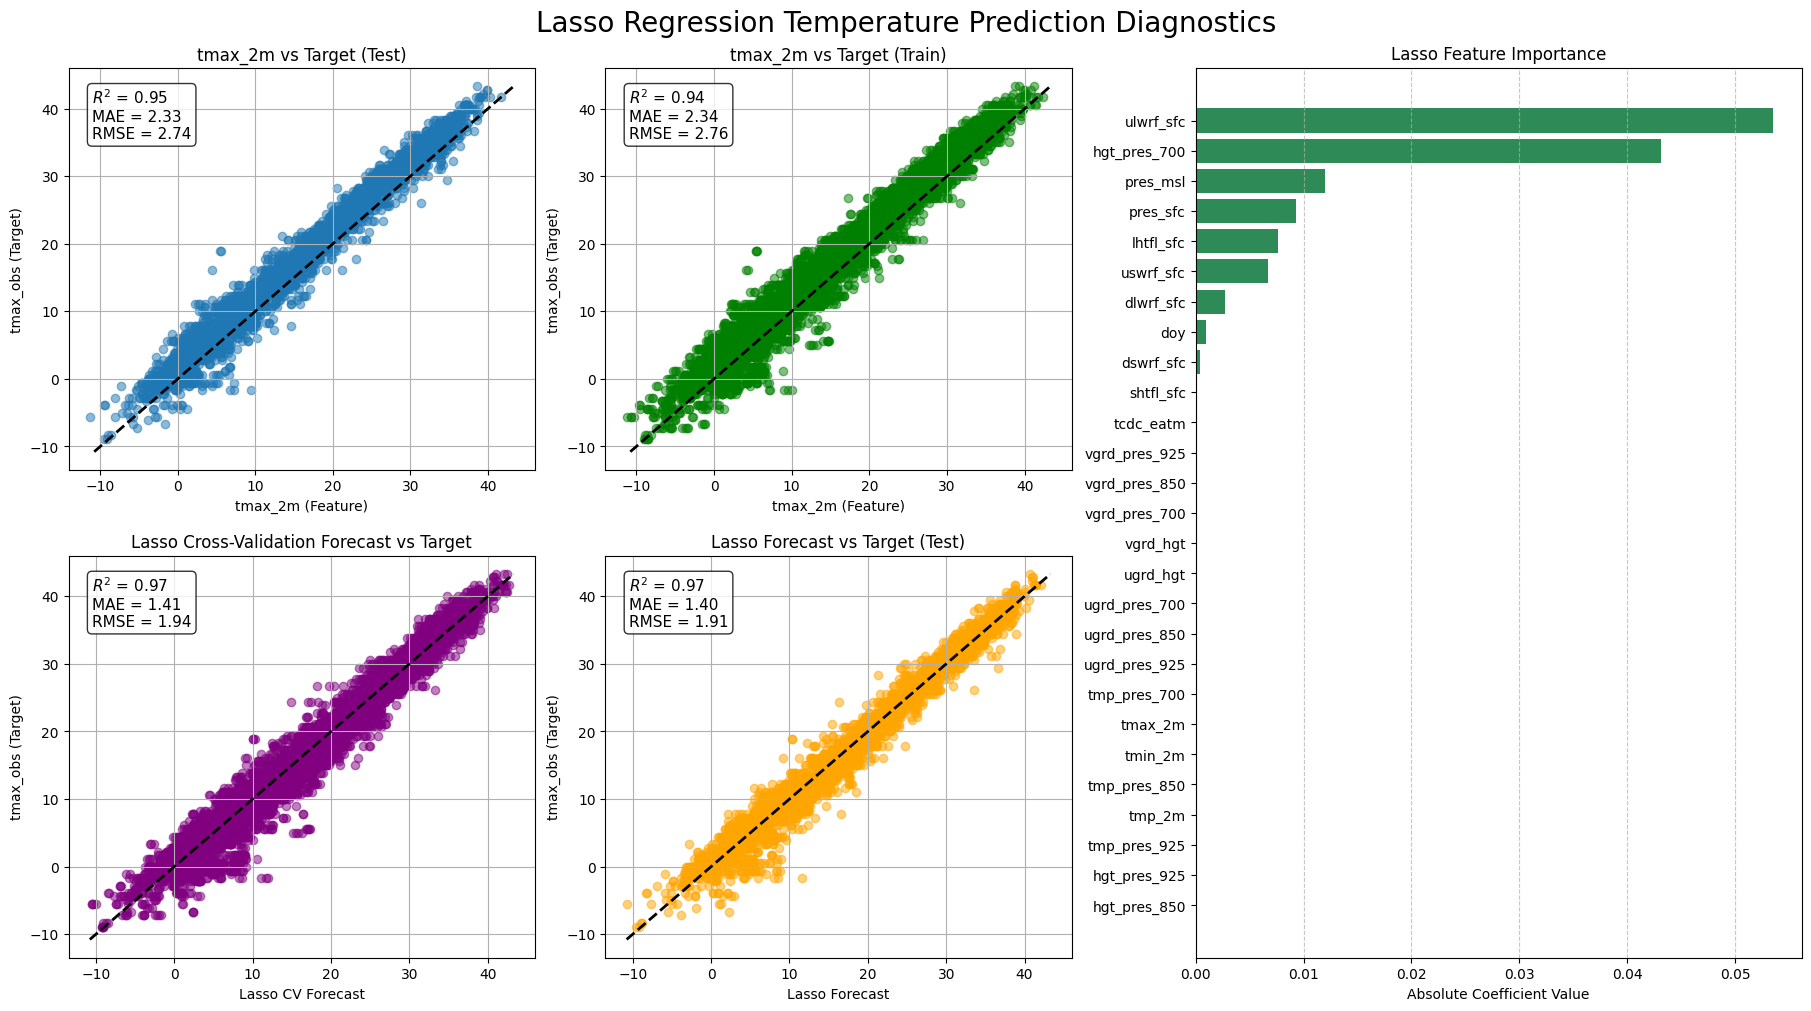

In [190]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assume X_train, X_val, X_test, y_train, y_val, y_test are already defined

# If X_train, X_val, X_test are numpy arrays, convert to DataFrame for feature names
if not isinstance(X_train, pd.DataFrame):
    feature_names = [f"X{i}" for i in range(X_train.shape[1])]
    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_val = pd.DataFrame(X_val, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names)
else:
    feature_names = X_train.columns

# Lasso regression with cross-validated alpha (regularization strength)
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train, y_train)

print("Best alpha (regularization strength):", lasso.alpha_)

# Cross-validation predictions for diagnostics
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_true = []
cv_pred = []
for train_index, test_index in kf.split(X_train):
    X_tr, X_te = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr = y_train.iloc[train_index] if hasattr(y_train, "iloc") else y_train[train_index]
    y_te = y_train.iloc[test_index] if hasattr(y_train, "iloc") else y_train[test_index]
    lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
    lasso_cv.fit(X_tr, y_tr)
    y_te_pred = lasso_cv.predict(X_te)
    cv_true.append(y_te)
    cv_pred.append(y_te_pred)
cv_true = np.concatenate(cv_true)
cv_pred = np.concatenate(cv_pred)
cv_r2 = r2_score(cv_true, cv_pred)
cv_mae = mean_absolute_error(cv_true, cv_pred)
cv_rmse = np.sqrt(mean_squared_error(cv_true, cv_pred))
print(f"Cross-validated R2: {cv_r2:.4f}")

def print_metrics(name, y_true, y_pred):
    print(f"{name} R2:   {r2_score(y_true, y_pred):.4f}")
    print(f"{name} MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")

# Validation metrics
y_val_pred = lasso.predict(X_val)
print_metrics("Validation", y_val, y_val_pred)

# Test metrics
y_test_pred = lasso.predict(X_test)
print_metrics("Test", y_test, y_test_pred)

# For plotting
min_val = min(np.min(y_test), np.min(y_test_pred), np.min(cv_true), np.min(cv_pred))
max_val = max(np.max(y_test), np.max(y_test_pred), np.max(cv_true), np.max(cv_pred))

fig = plt.figure(figsize=(18, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1.3], height_ratios=[1, 1], figure=fig)

axes = {}
axes['tl'] = fig.add_subplot(gs[0, 0])
axes['tm'] = fig.add_subplot(gs[0, 1])
axes['bl'] = fig.add_subplot(gs[1, 0])
axes['bm'] = fig.add_subplot(gs[1, 1])
ax_feat = fig.add_subplot(gs[:, 2])

# 1. Top left: Test set tmax_2m vs tmax_obs
axes['tl'].scatter(X_test['tmax_2m'], y_test, alpha=0.5)
axes['tl'].set_xlabel('tmax_2m (Feature)')
axes['tl'].set_ylabel('tmax_obs (Target)')
axes['tl'].set_title('tmax_2m vs Target (Test)')
axes['tl'].grid(True)
axes['tl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_left = r2_score(y_test, X_test['tmax_2m'])
mae_left = mean_absolute_error(y_test, X_test['tmax_2m'])
rmse_left = np.sqrt(mean_squared_error(y_test, X_test['tmax_2m']))
metrics_text_left = f"$R^2$ = {r2_left:.2f}\nMAE = {mae_left:.2f}\nRMSE = {rmse_left:.2f}"
axes['tl'].annotate(metrics_text_left, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Top middle: Train set tmax_2m vs tmax_obs
axes['tm'].scatter(X_train['tmax_2m'], y_train, alpha=0.5, color='green')
axes['tm'].set_xlabel('tmax_2m (Feature)')
axes['tm'].set_ylabel('tmax_obs (Target)')
axes['tm'].set_title('tmax_2m vs Target (Train)')
axes['tm'].grid(True)
axes['tm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_train = r2_score(y_train, X_train['tmax_2m'])
mae_train = mean_absolute_error(y_train, X_train['tmax_2m'])
rmse_train = np.sqrt(mean_squared_error(y_train, X_train['tmax_2m']))
metrics_text_train = f"$R^2$ = {r2_train:.2f}\nMAE = {mae_train:.2f}\nRMSE = {rmse_train:.2f}"
axes['tm'].annotate(metrics_text_train, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Bottom left: Lasso CV Forecast vs tmax_obs (cross-validation)
axes['bl'].scatter(cv_pred, cv_true, alpha=0.5, color='purple')
axes['bl'].set_xlabel('Lasso CV Forecast')
axes['bl'].set_ylabel('tmax_obs (Target)')
axes['bl'].set_title('Lasso Cross-Validation Forecast vs Target')
axes['bl'].grid(True)
axes['bl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
metrics_text_cv = f"$R^2$ = {cv_r2:.2f}\nMAE = {cv_mae:.2f}\nRMSE = {cv_rmse:.2f}"
axes['bl'].annotate(metrics_text_cv, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Bottom middle: Lasso Forecast vs tmax_obs (Test set)
axes['bm'].scatter(y_test_pred, y_test, alpha=0.5, color='orange')
axes['bm'].set_xlabel('Lasso Forecast')
axes['bm'].set_ylabel('tmax_obs (Target)')
axes['bm'].set_title('Lasso Forecast vs Target (Test)')
axes['bm'].grid(True)
axes['bm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
metrics_text_test = f"$R^2$ = {r2_test:.2f}\nMAE = {mae_test:.2f}\nRMSE = {rmse_test:.2f}"
axes['bm'].annotate(metrics_text_test, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Feature importance (right): Absolute value of coefficients
coef_importance = np.abs(lasso.coef_)
sorted_idx = np.argsort(coef_importance)
ax_feat.barh(np.array(feature_names)[sorted_idx], coef_importance[sorted_idx], color='seagreen')
ax_feat.set_xlabel('Absolute Coefficient Value')
ax_feat.set_title('Lasso Feature Importance')
ax_feat.grid(axis='x', linestyle='--', alpha=0.7)

fig.suptitle("Lasso Regression Temperature Prediction Diagnostics", fontsize=20)
plt.show()

Best alpha (regularization strength): 1.0974987654930568
Cross-validated R2: 0.9785
Validation R2:   0.9780
Validation MAE:  1.2342
Validation RMSE: 1.7085
Test R2:   0.9799
Test MAE:  1.2111
Test RMSE: 1.6651


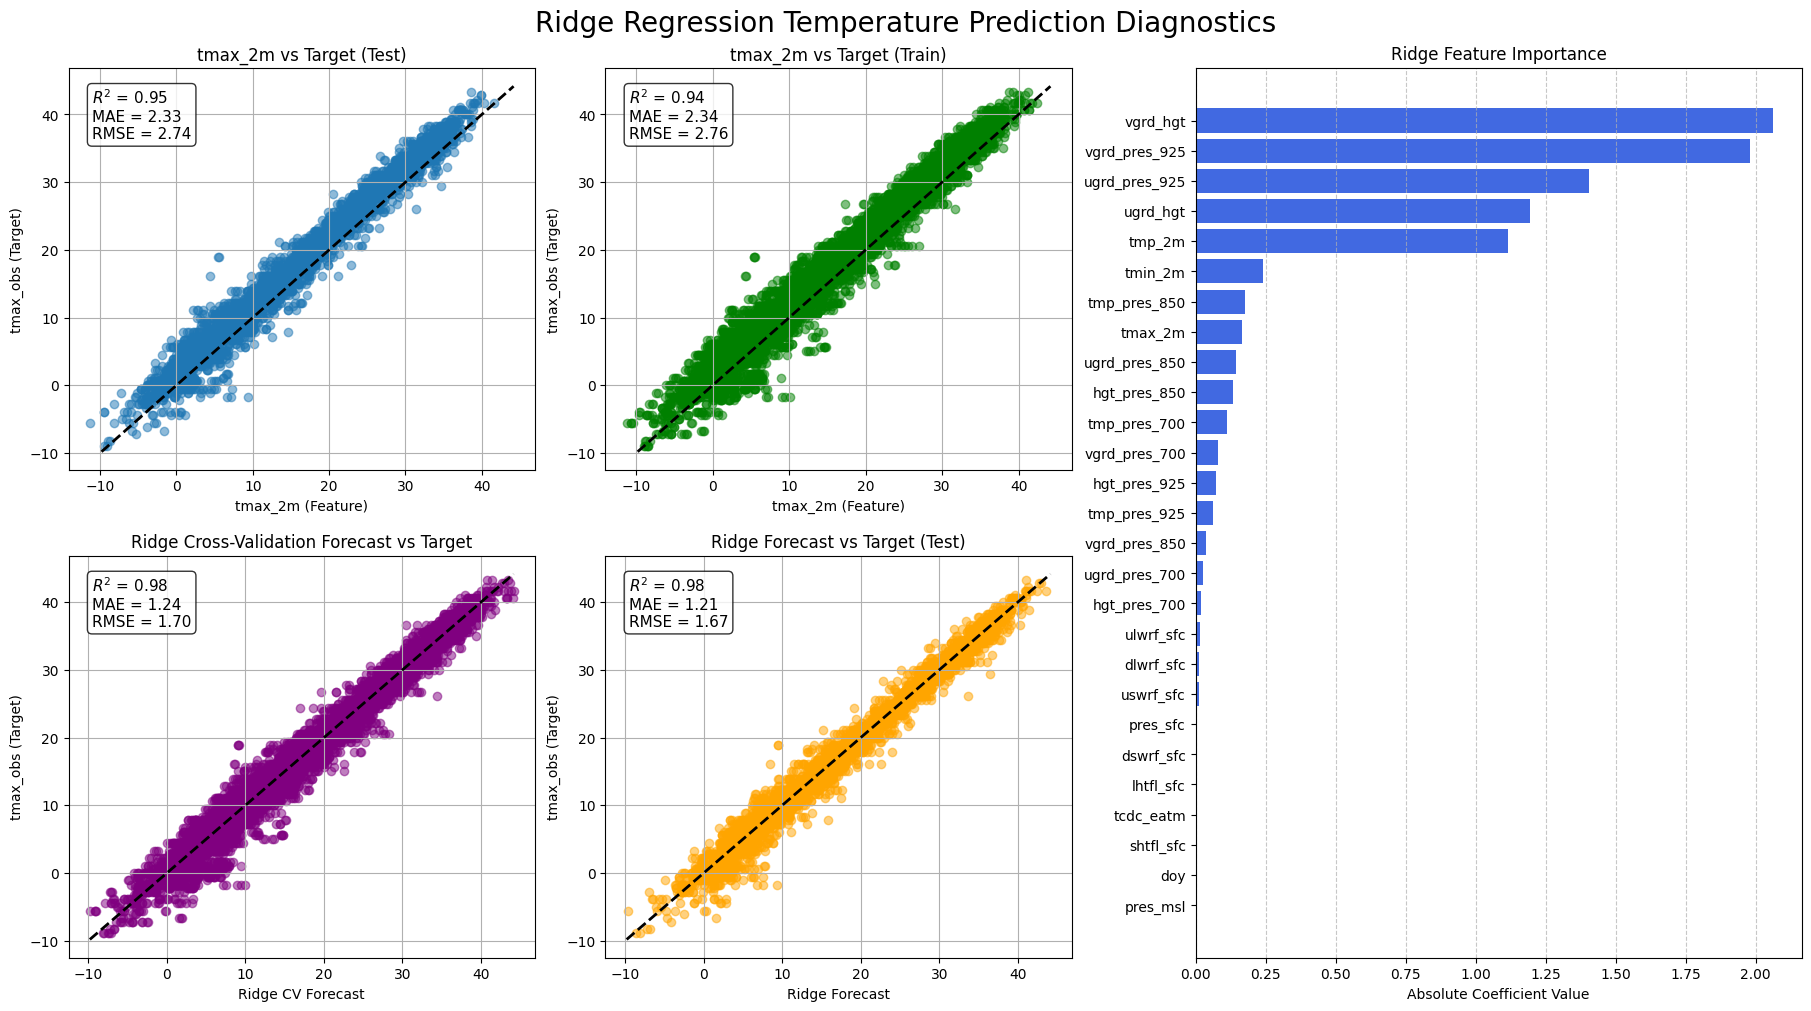

In [189]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assume X_train, X_val, X_test, y_train, y_val, y_test are already defined

# If X_train, X_val, X_test are numpy arrays, convert to DataFrame for feature names
if not isinstance(X_train, pd.DataFrame):
    feature_names = [f"X{i}" for i in range(X_train.shape[1])]
    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_val = pd.DataFrame(X_val, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names)
else:
    feature_names = X_train.columns

# Ridge regression with cross-validated alpha (regularization strength)
alphas = np.logspace(-4, 4, 100)
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train, y_train)

print("Best alpha (regularization strength):", ridge.alpha_)

# Cross-validation predictions for diagnostics
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_true = []
cv_pred = []
for train_index, test_index in kf.split(X_train):
    X_tr, X_te = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr = y_train.iloc[train_index] if hasattr(y_train, "iloc") else y_train[train_index]
    y_te = y_train.iloc[test_index] if hasattr(y_train, "iloc") else y_train[test_index]
    ridge_cv = RidgeCV(alphas=alphas, cv=5)
    ridge_cv.fit(X_tr, y_tr)
    y_te_pred = ridge_cv.predict(X_te)
    cv_true.append(y_te)
    cv_pred.append(y_te_pred)
cv_true = np.concatenate(cv_true)
cv_pred = np.concatenate(cv_pred)
cv_r2 = r2_score(cv_true, cv_pred)
cv_mae = mean_absolute_error(cv_true, cv_pred)
cv_rmse = np.sqrt(mean_squared_error(cv_true, cv_pred))
print(f"Cross-validated R2: {cv_r2:.4f}")

def print_metrics(name, y_true, y_pred):
    print(f"{name} R2:   {r2_score(y_true, y_pred):.4f}")
    print(f"{name} MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")

# Validation metrics
y_val_pred = ridge.predict(X_val)
print_metrics("Validation", y_val, y_val_pred)

# Test metrics
y_test_pred = ridge.predict(X_test)
print_metrics("Test", y_test, y_test_pred)

# For plotting
min_val = min(np.min(y_test), np.min(y_test_pred), np.min(cv_true), np.min(cv_pred))
max_val = max(np.max(y_test), np.max(y_test_pred), np.max(cv_true), np.max(cv_pred))

fig = plt.figure(figsize=(18, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1.3], height_ratios=[1, 1], figure=fig)

axes = {}
axes['tl'] = fig.add_subplot(gs[0, 0])
axes['tm'] = fig.add_subplot(gs[0, 1])
axes['bl'] = fig.add_subplot(gs[1, 0])
axes['bm'] = fig.add_subplot(gs[1, 1])
ax_feat = fig.add_subplot(gs[:, 2])

# 1. Top left: Test set tmax_2m vs tmax_obs
axes['tl'].scatter(X_test['tmax_2m'], y_test, alpha=0.5)
axes['tl'].set_xlabel('tmax_2m (Feature)')
axes['tl'].set_ylabel('tmax_obs (Target)')
axes['tl'].set_title('tmax_2m vs Target (Test)')
axes['tl'].grid(True)
axes['tl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_left = r2_score(y_test, X_test['tmax_2m'])
mae_left = mean_absolute_error(y_test, X_test['tmax_2m'])
rmse_left = np.sqrt(mean_squared_error(y_test, X_test['tmax_2m']))
metrics_text_left = f"$R^2$ = {r2_left:.2f}\nMAE = {mae_left:.2f}\nRMSE = {rmse_left:.2f}"
axes['tl'].annotate(metrics_text_left, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Top middle: Train set tmax_2m vs tmax_obs
axes['tm'].scatter(X_train['tmax_2m'], y_train, alpha=0.5, color='green')
axes['tm'].set_xlabel('tmax_2m (Feature)')
axes['tm'].set_ylabel('tmax_obs (Target)')
axes['tm'].set_title('tmax_2m vs Target (Train)')
axes['tm'].grid(True)
axes['tm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_train = r2_score(y_train, X_train['tmax_2m'])
mae_train = mean_absolute_error(y_train, X_train['tmax_2m'])
rmse_train = np.sqrt(mean_squared_error(y_train, X_train['tmax_2m']))
metrics_text_train = f"$R^2$ = {r2_train:.2f}\nMAE = {mae_train:.2f}\nRMSE = {rmse_train:.2f}"
axes['tm'].annotate(metrics_text_train, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Bottom left: Ridge CV Forecast vs tmax_obs (cross-validation)
axes['bl'].scatter(cv_pred, cv_true, alpha=0.5, color='purple')
axes['bl'].set_xlabel('Ridge CV Forecast')
axes['bl'].set_ylabel('tmax_obs (Target)')
axes['bl'].set_title('Ridge Cross-Validation Forecast vs Target')
axes['bl'].grid(True)
axes['bl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
metrics_text_cv = f"$R^2$ = {cv_r2:.2f}\nMAE = {cv_mae:.2f}\nRMSE = {cv_rmse:.2f}"
axes['bl'].annotate(metrics_text_cv, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Bottom middle: Ridge Forecast vs tmax_obs (Test set)
axes['bm'].scatter(y_test_pred, y_test, alpha=0.5, color='orange')
axes['bm'].set_xlabel('Ridge Forecast')
axes['bm'].set_ylabel('tmax_obs (Target)')
axes['bm'].set_title('Ridge Forecast vs Target (Test)')
axes['bm'].grid(True)
axes['bm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
metrics_text_test = f"$R^2$ = {r2_test:.2f}\nMAE = {mae_test:.2f}\nRMSE = {rmse_test:.2f}"
axes['bm'].annotate(metrics_text_test, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Feature importance (right): Absolute value of coefficients
coef_importance = np.abs(ridge.coef_)
sorted_idx = np.argsort(coef_importance)
ax_feat.barh(np.array(feature_names)[sorted_idx], coef_importance[sorted_idx], color='royalblue')
ax_feat.set_xlabel('Absolute Coefficient Value')
ax_feat.set_title('Ridge Feature Importance')
ax_feat.grid(axis='x', linestyle='--', alpha=0.7)

fig.suptitle("Ridge Regression Temperature Prediction Diagnostics", fontsize=20)
plt.show()

Cross-validated RMSE: 1.3819
Cross-validated R2: 0.9858
Validation R2:   0.9935
Validation MAE:  0.7060
Validation RMSE: 0.9321
Test R2:   0.9884
Test MAE:  0.9304
Test RMSE: 1.2617


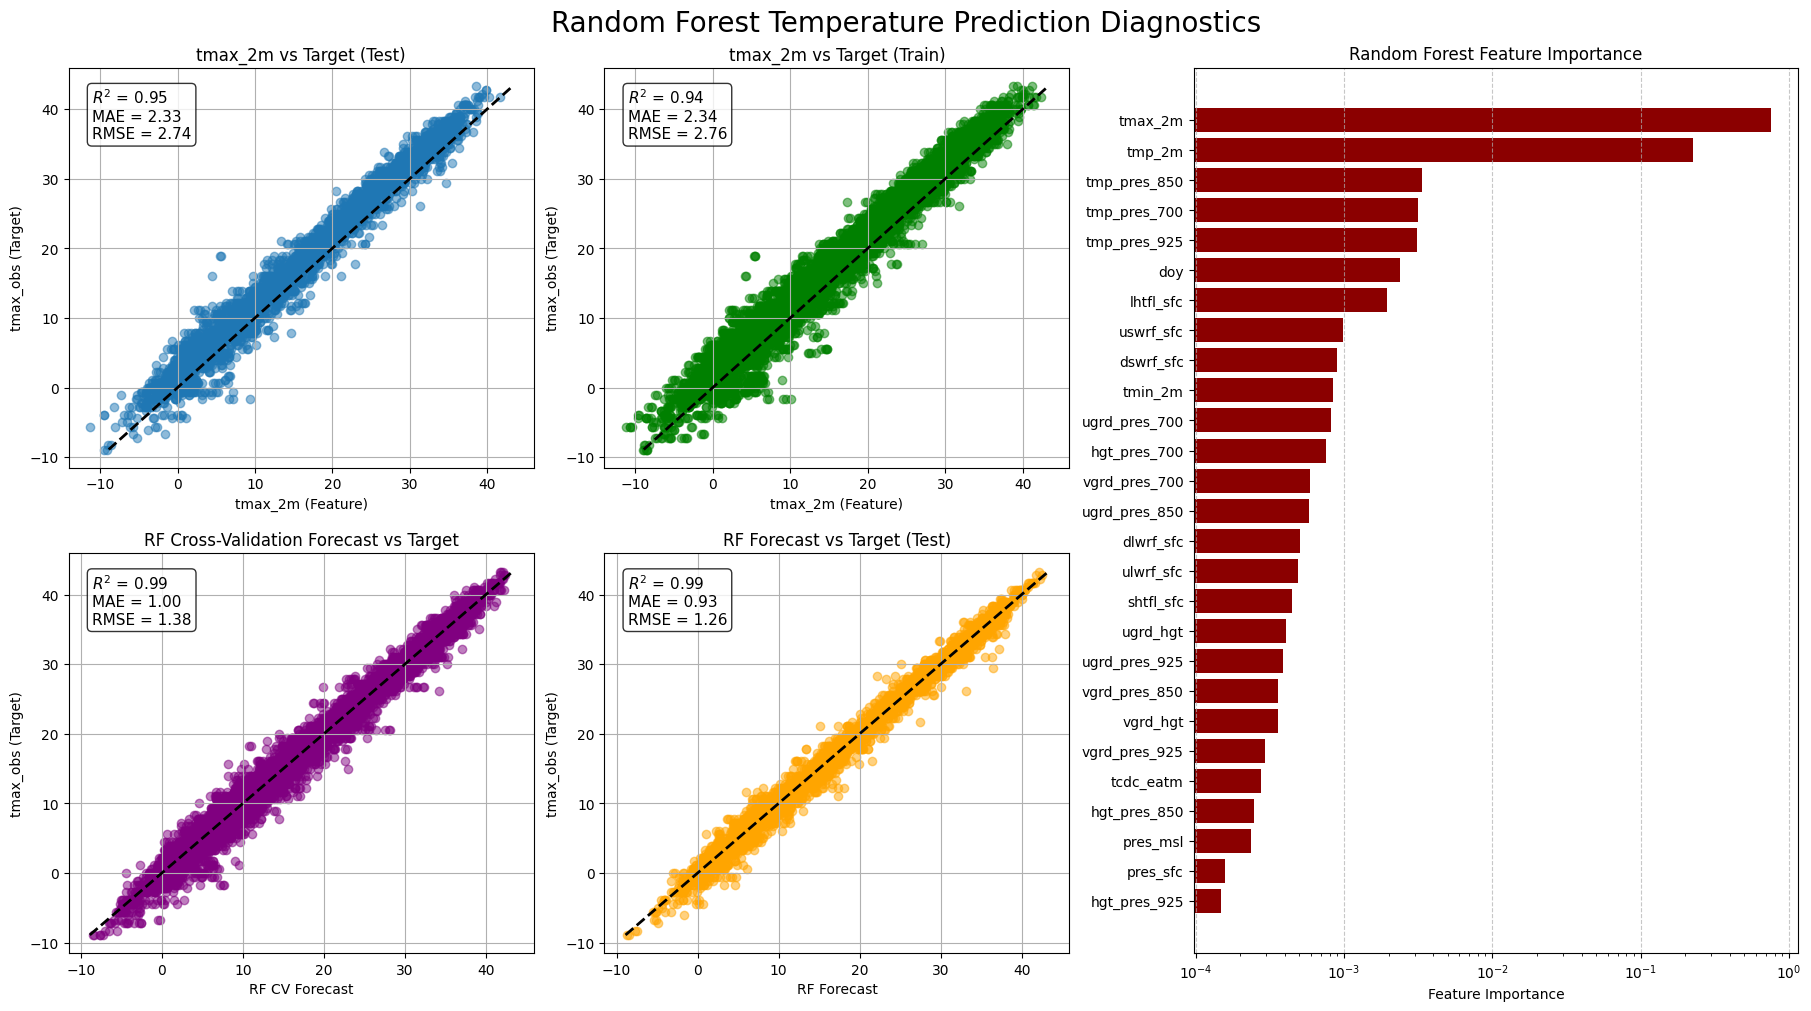

In [187]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assume X_train, X_val, X_test, y_train, y_val, y_test are already defined

# Convert to DataFrame if needed
if not isinstance(X_train, pd.DataFrame):
    feature_names = [f"X{i}" for i in range(X_train.shape[1])]
    X_train = pd.DataFrame(X_train, columns=feature_names)
    X_val = pd.DataFrame(X_val, columns=feature_names)
    X_test = pd.DataFrame(X_test, columns=feature_names)
else:
    feature_names = X_train.columns

# --------- Random Forest Early Stopping (Validation RMSE) ---------
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    n_jobs=-1,
    random_state=42,
    oob_score=False,
    warm_start=True
)

best_val_rmse = np.inf
patience = 10
patience_counter = 0
best_rf = None
history = []
for n in range(10, 101, 10):
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    y_val_pred = rf.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    history.append(val_rmse)
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        patience_counter = 0
        best_rf = RandomForestRegressor(
            n_estimators=n,
            max_depth=10,
            n_jobs=-1,
            random_state=42,
            oob_score=False
        )
        best_rf.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at {n} trees, best RMSE on val: {best_val_rmse:.4f}")
            break

rf = best_rf if best_rf is not None else rf

# --------- Cross-validation (CV predictions for scatterplot) ---------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_true = []
cv_pred = []
for train_index, test_index in kf.split(X_train):
    X_tr, X_te = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr = y_train.iloc[train_index] if hasattr(y_train, "iloc") else y_train[train_index]
    y_te = y_train.iloc[test_index] if hasattr(y_train, "iloc") else y_train[test_index]
    rf_cv = RandomForestRegressor(
        n_estimators=rf.n_estimators,
        max_depth=10,
        n_jobs=-1,
        random_state=42
    )
    rf_cv.fit(X_tr, y_tr)
    y_te_pred = rf_cv.predict(X_te)
    cv_true.append(y_te)
    cv_pred.append(y_te_pred)
cv_true = np.concatenate(cv_true)
cv_pred = np.concatenate(cv_pred)
cv_r2 = r2_score(cv_true, cv_pred)
cv_mae = mean_absolute_error(cv_true, cv_pred)
cv_rmse = np.sqrt(mean_squared_error(cv_true, cv_pred))
print(f"Cross-validated RMSE: {cv_rmse:.4f}")
print(f"Cross-validated R2: {cv_r2:.4f}")

def print_metrics(name, y_true, y_pred):
    print(f"{name} R2:   {r2_score(y_true, y_pred):.4f}")
    print(f"{name} MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")

# Validation metrics
y_val_pred = rf.predict(X_val)
print_metrics("Validation", y_val, y_val_pred)

# Test metrics
y_test_pred = rf.predict(X_test)
print_metrics("Test", y_test, y_test_pred)

# --------- PLOTTING (GridSpec style, with suptitle and 2x2+right) ---------
min_val = min(np.min(y_test), np.min(y_test_pred), np.min(cv_true), np.min(cv_pred))
max_val = max(np.max(y_test), np.max(y_test_pred), np.max(cv_true), np.max(cv_pred))

fig = plt.figure(figsize=(18, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1.3], height_ratios=[1, 1], figure=fig)

axes = {}
axes['tl'] = fig.add_subplot(gs[0, 0])
axes['tm'] = fig.add_subplot(gs[0, 1])
axes['bl'] = fig.add_subplot(gs[1, 0])
axes['bm'] = fig.add_subplot(gs[1, 1])
ax_feat = fig.add_subplot(gs[:, 2])

# 1. Top left: Test set tmax_2m vs tmax_obs
axes['tl'].scatter(X_test['tmax_2m'], y_test, alpha=0.5)
axes['tl'].set_xlabel('tmax_2m (Feature)')
axes['tl'].set_ylabel('tmax_obs (Target)')
axes['tl'].set_title('tmax_2m vs Target (Test)')
axes['tl'].grid(True)
axes['tl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_left = r2_score(y_test, X_test['tmax_2m'])
mae_left = mean_absolute_error(y_test, X_test['tmax_2m'])
rmse_left = np.sqrt(mean_squared_error(y_test, X_test['tmax_2m']))
metrics_text_left = f"$R^2$ = {r2_left:.2f}\nMAE = {mae_left:.2f}\nRMSE = {rmse_left:.2f}"
axes['tl'].annotate(metrics_text_left, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Top middle: Train set tmax_2m vs tmax_obs
axes['tm'].scatter(X_train['tmax_2m'], y_train, alpha=0.5, color='green')
axes['tm'].set_xlabel('tmax_2m (Feature)')
axes['tm'].set_ylabel('tmax_obs (Target)')
axes['tm'].set_title('tmax_2m vs Target (Train)')
axes['tm'].grid(True)
axes['tm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_train = r2_score(y_train, X_train['tmax_2m'])
mae_train = mean_absolute_error(y_train, X_train['tmax_2m'])
rmse_train = np.sqrt(mean_squared_error(y_train, X_train['tmax_2m']))
metrics_text_train = f"$R^2$ = {r2_train:.2f}\nMAE = {mae_train:.2f}\nRMSE = {rmse_train:.2f}"
axes['tm'].annotate(metrics_text_train, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Bottom left: RF CV Forecast vs tmax_obs (cross-validation)
axes['bl'].scatter(cv_pred, cv_true, alpha=0.5, color='purple')
axes['bl'].set_xlabel('RF CV Forecast')
axes['bl'].set_ylabel('tmax_obs (Target)')
axes['bl'].set_title('RF Cross-Validation Forecast vs Target')
axes['bl'].grid(True)
axes['bl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
metrics_text_cv = f"$R^2$ = {cv_r2:.2f}\nMAE = {cv_mae:.2f}\nRMSE = {cv_rmse:.2f}"
axes['bl'].annotate(metrics_text_cv, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Bottom middle: RF Forecast vs tmax_obs (Test set)
axes['bm'].scatter(y_test_pred, y_test, alpha=0.5, color='orange')
axes['bm'].set_xlabel('RF Forecast')
axes['bm'].set_ylabel('tmax_obs (Target)')
axes['bm'].set_title('RF Forecast vs Target (Test)')
axes['bm'].grid(True)
axes['bm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
metrics_text_test = f"$R^2$ = {r2_test:.2f}\nMAE = {mae_test:.2f}\nRMSE = {rmse_test:.2f}"
axes['bm'].annotate(metrics_text_test, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Feature importance (right)
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)
ax_feat.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx], color='darkred')
ax_feat.set_xlabel('Feature Importance')
ax_feat.set_title('Random Forest Feature Importance')
ax_feat.grid(axis='x', linestyle='--', alpha=0.7)
ax_feat.set_xscale('log')

fig.suptitle("Random Forest Temperature Prediction Diagnostics", fontsize=20)
plt.show()

Cross-validated R2: 0.9890287077739315
Validation R2:   0.9894
Validation MAE:  0.7963
Validation RMSE: 1.1966
Test R2:   0.9901
Test MAE:  0.7894
Test RMSE: 1.1537


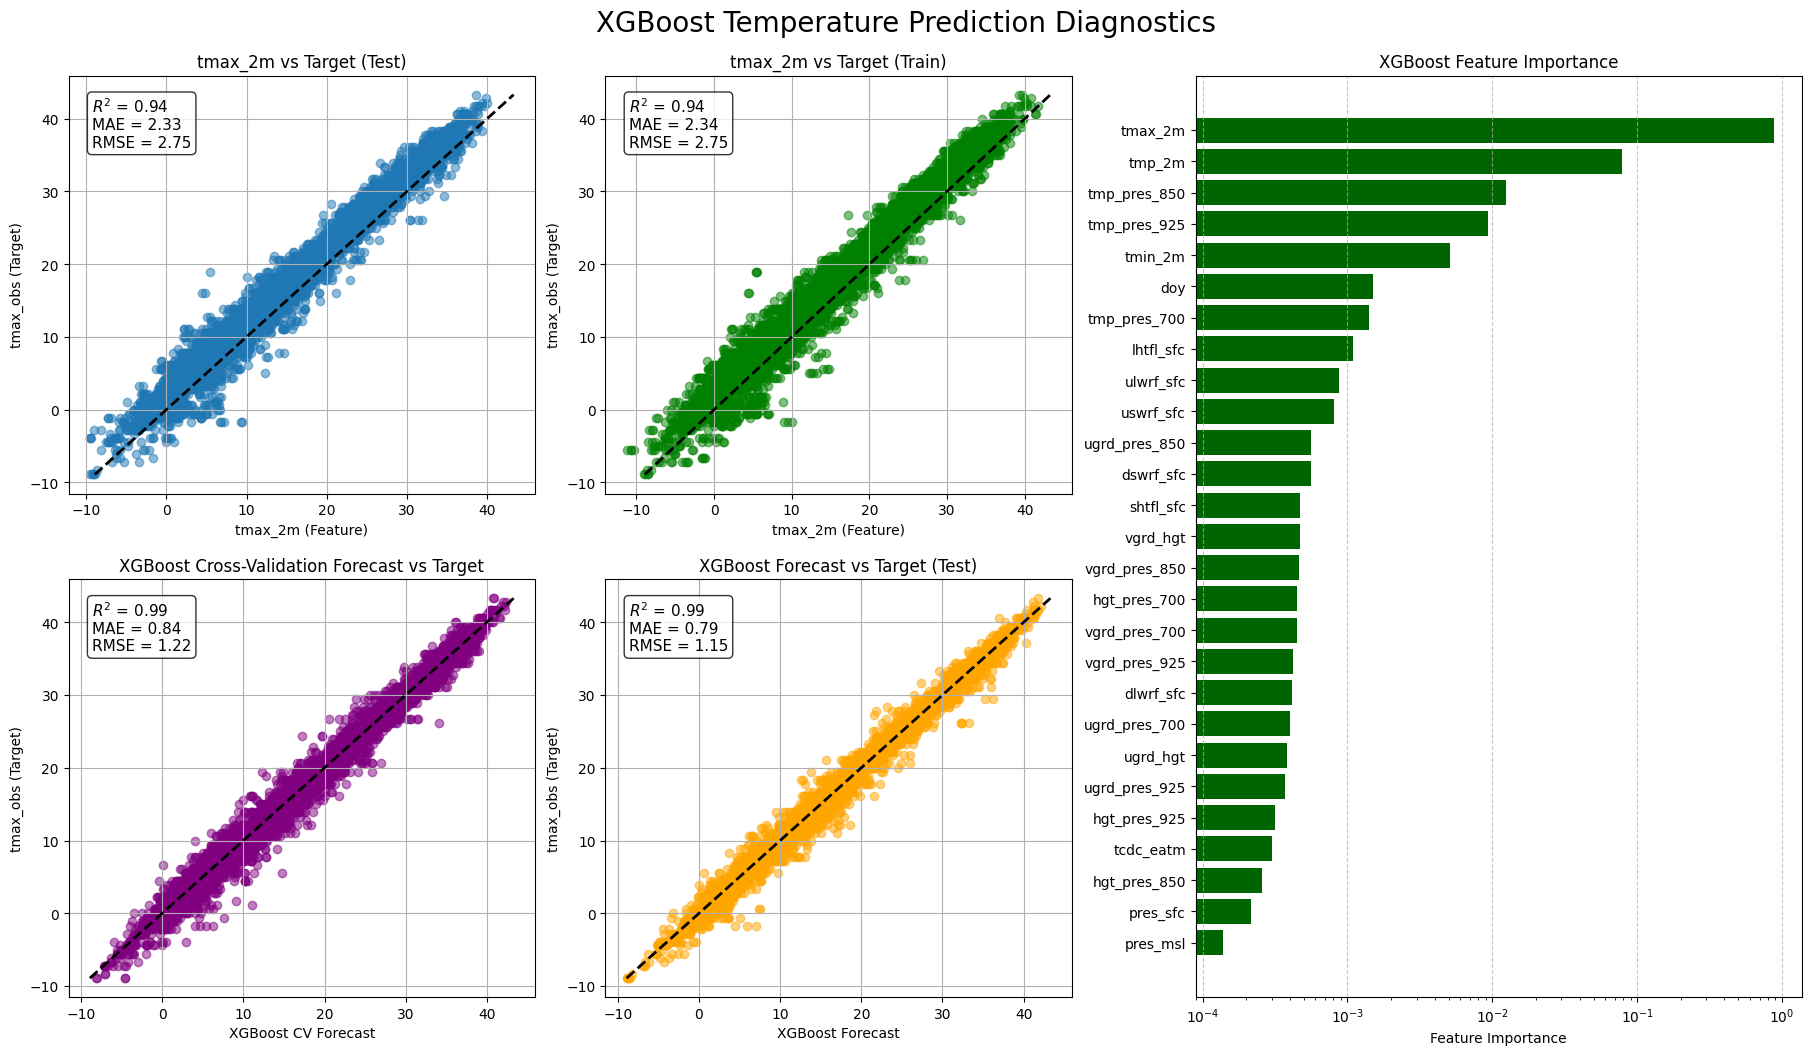

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --------- XGBOOST MODELING ----------
# Cross-validation (no early stopping)
cv_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    eval_metric='rmse'
)
# Collect CV predictions as well as scores
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_true = []
cv_pred = []
for train_index, test_index in kf.split(X_train):
    X_tr, X_te = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr = y_train.iloc[train_index] if hasattr(y_train, "iloc") else y_train[train_index]
    y_te = y_train.iloc[test_index] if hasattr(y_train, "iloc") else y_train[test_index]
    model_cv = XGBRegressor(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        n_jobs=-1,
        random_state=42,
        eval_metric='rmse'
    )
    model_cv.fit(X_tr, y_tr)
    y_te_pred = model_cv.predict(X_te)
    cv_true.append(y_te)
    cv_pred.append(y_te_pred)
cv_true = np.concatenate(cv_true)
cv_pred = np.concatenate(cv_pred)
cv_r2 = r2_score(cv_true, cv_pred)
cv_mae = mean_absolute_error(cv_true, cv_pred)
cv_rmse = np.sqrt(mean_squared_error(cv_true, cv_pred))
cv_scores = cross_val_score(cv_xgb, X_train, y_train, cv=5, scoring='r2')
print('Cross-validated R2:', np.mean(cv_scores))

xgb = XGBRegressor(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    eval_metric='rmse'
)
xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

def print_metrics(name, y_true, y_pred):
    print(f"{name} R2:   {r2_score(y_true, y_pred):.4f}")
    print(f"{name} MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")

# Validation metrics
y_val_pred = xgb.predict(X_val)
print_metrics("Validation", y_val, y_val_pred)

# Test metrics
y_test_pred = xgb.predict(X_test)
print_metrics("Test", y_test, y_test_pred)

# --------- PLOTTING (GridSpec style) ----------
feature_names = X_train.columns
min_val = min(np.min(y_test), np.min(y_test_pred), np.min(cv_true), np.min(cv_pred))
max_val = max(np.max(y_test), np.max(y_test_pred), np.max(cv_true), np.max(cv_pred))

fig = plt.figure(figsize=(18, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1.3], height_ratios=[1, 1], figure=fig)

axes = {}
axes['tl'] = plt.subplot(gs[0, 0])      # top left
axes['tm'] = plt.subplot(gs[0, 1])      # top middle
axes['bl'] = plt.subplot(gs[1, 0])      # bottom left
axes['bm'] = plt.subplot(gs[1, 1])      # bottom middle
ax_feat = plt.subplot(gs[:, 2])         # right, spanning both rows

# 1. Top left: Test set tmax_2m vs tmax_obs
axes['tl'].scatter(X_test['tmax_2m'], y_test, alpha=0.5)
axes['tl'].set_xlabel('tmax_2m (Feature)')
axes['tl'].set_ylabel('tmax_obs (Target)')
axes['tl'].set_title('tmax_2m vs Target (Test)')
axes['tl'].grid(True)
axes['tl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_left = r2_score(y_test, X_test['tmax_2m'])
mae_left = mean_absolute_error(y_test, X_test['tmax_2m'])
rmse_left = np.sqrt(mean_squared_error(y_test, X_test['tmax_2m']))
metrics_text_left = f"$R^2$ = {r2_left:.2f}\nMAE = {mae_left:.2f}\nRMSE = {rmse_left:.2f}"
axes['tl'].annotate(metrics_text_left, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Top middle: Train set tmax_2m vs tmax_obs
axes['tm'].scatter(X_train['tmax_2m'], y_train, alpha=0.5, color='green')
axes['tm'].set_xlabel('tmax_2m (Feature)')
axes['tm'].set_ylabel('tmax_obs (Target)')
axes['tm'].set_title('tmax_2m vs Target (Train)')
axes['tm'].grid(True)
axes['tm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_train = r2_score(y_train, X_train['tmax_2m'])
mae_train = mean_absolute_error(y_train, X_train['tmax_2m'])
rmse_train = np.sqrt(mean_squared_error(y_train, X_train['tmax_2m']))
metrics_text_train = f"$R^2$ = {r2_train:.2f}\nMAE = {mae_train:.2f}\nRMSE = {rmse_train:.2f}"
axes['tm'].annotate(metrics_text_train, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Bottom left: XGBoost CV Forecast vs tmax_obs (cross-validation)
axes['bl'].scatter(cv_pred, cv_true, alpha=0.5, color='purple')
axes['bl'].set_xlabel('XGBoost CV Forecast')
axes['bl'].set_ylabel('tmax_obs (Target)')
axes['bl'].set_title('XGBoost Cross-Validation Forecast vs Target')
axes['bl'].grid(True)
axes['bl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
metrics_text_cv = f"$R^2$ = {cv_r2:.2f}\nMAE = {cv_mae:.2f}\nRMSE = {cv_rmse:.2f}"
axes['bl'].annotate(metrics_text_cv, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Bottom middle: XGBoost Forecast vs tmax_obs (Test set)
axes['bm'].scatter(y_test_pred, y_test, alpha=0.5, color='orange')
axes['bm'].set_xlabel('XGBoost Forecast')
axes['bm'].set_ylabel('tmax_obs (Target)')
axes['bm'].set_title('XGBoost Forecast vs Target (Test)')
axes['bm'].grid(True)
axes['bm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
metrics_text_test = f"$R^2$ = {r2_test:.2f}\nMAE = {mae_test:.2f}\nRMSE = {rmse_test:.2f}"
axes['bm'].annotate(metrics_text_test, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Feature importance (right)
importances = xgb.feature_importances_
sorted_idx = np.argsort(importances)
ax_feat.barh(np.array(feature_names)[sorted_idx], importances[sorted_idx], color='darkgreen')
ax_feat.set_xlabel('Feature Importance')
ax_feat.set_title('XGBoost Feature Importance')
ax_feat.grid(axis='x', linestyle='--', alpha=0.7)
ax_feat.set_xscale('log')

# Add a suptitle!
plt.suptitle("XGBoost Temperature Prediction Diagnostics", fontsize=20, y=1.04)
plt.show()

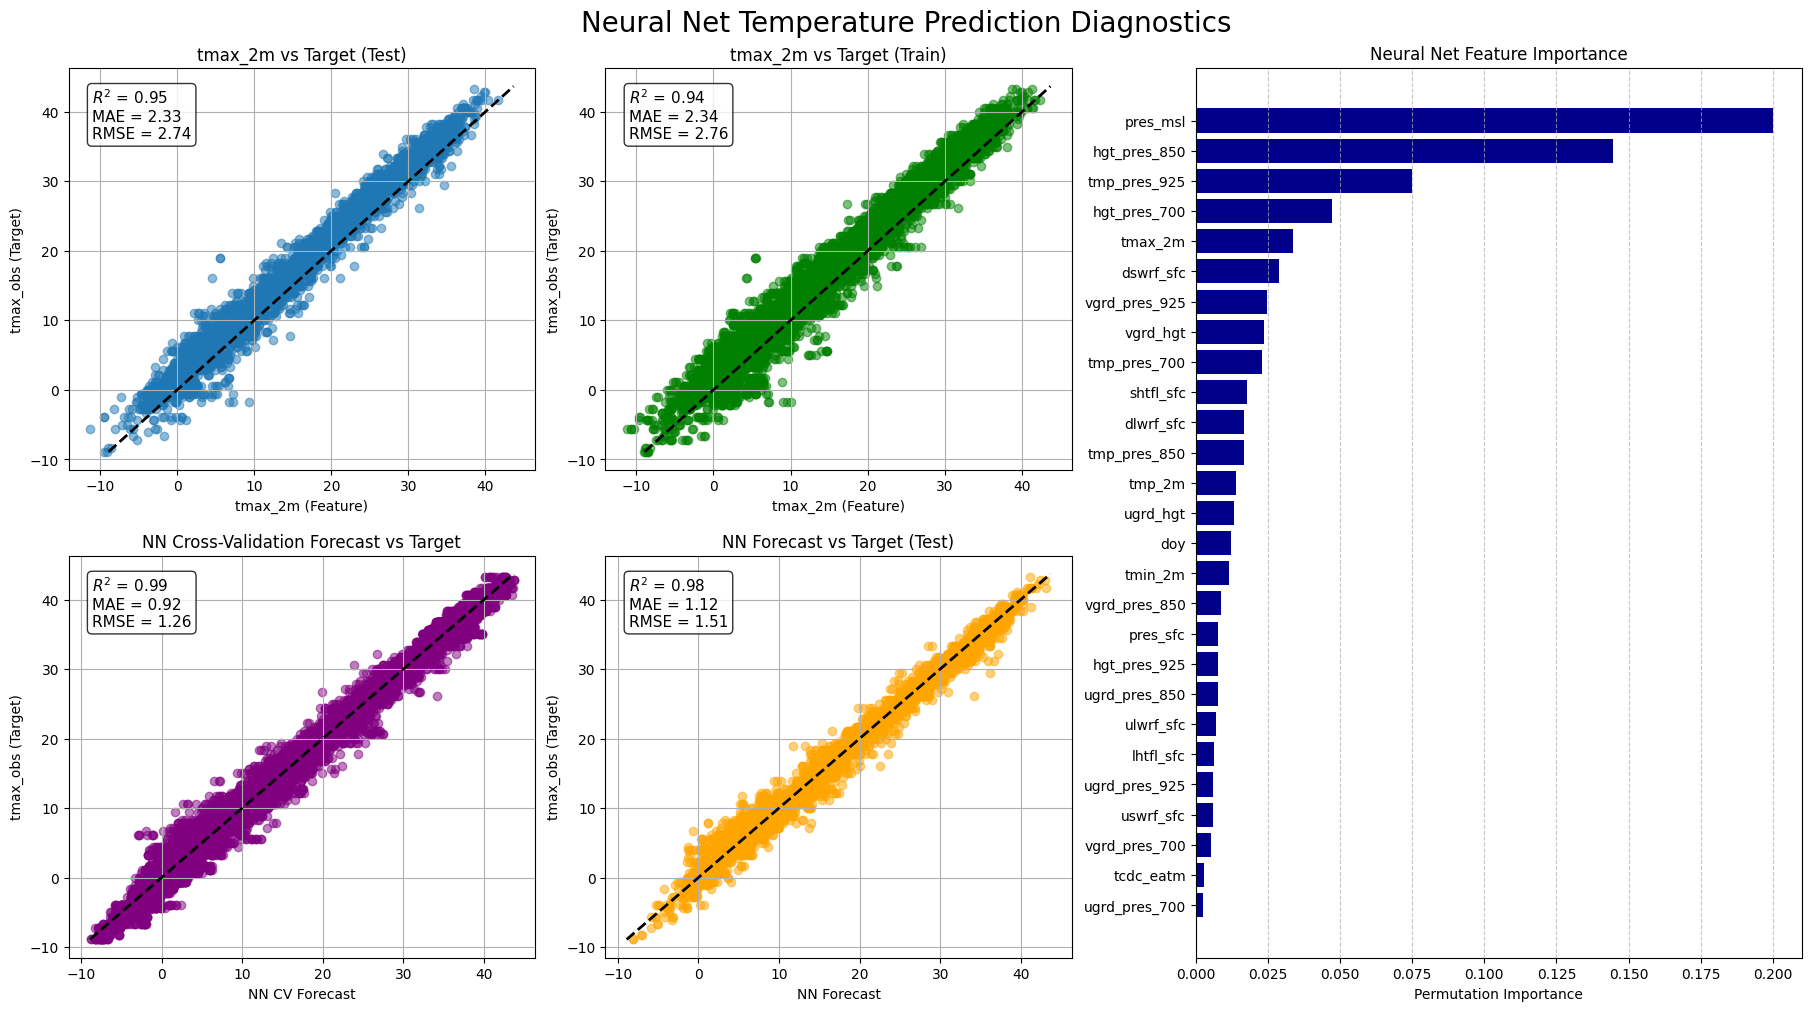

In [186]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# --------- FEATURE ENGINEERING ----------
if 'humidity' in X.columns and 'tmax_2m' in X.columns:
    X['humidity_tmax_2m'] = X['humidity'] * X['tmax_2m']
if 'dewpoint' in X.columns:
    X['dewpoint_sq'] = X['dewpoint'] ** 2
if 'dayofyear' not in X.columns and 'date' in X.columns:
    X['dayofyear'] = pd.to_datetime(X['date']).dt.dayofyear

# --------- SPLIT DATA ----------
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# --------- STANDARDIZE INPUTS ----------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
feature_names = X_train.columns

# --------- REBALANCE TRAINING DATA (UPSAMPLE EXTREME PERCENTILES) ----------
lower_pct, upper_pct = 10, 90
lower_q = np.percentile(y_train, lower_pct)
upper_q = np.percentile(y_train, upper_pct)

low_idx = np.where(y_train <= lower_q)[0]
high_idx = np.where(y_train >= upper_q)[0]
mid_idx = np.where((y_train > lower_q) & (y_train < upper_q))[0]
n_extreme = max(len(low_idx), len(high_idx), len(mid_idx))
low_upsampled_idx = np.random.choice(low_idx, n_extreme, replace=True)
high_upsampled_idx = np.random.choice(high_idx, n_extreme, replace=True)
mid_upsampled_idx = np.random.choice(mid_idx, n_extreme, replace=True)
all_idx = np.concatenate([low_upsampled_idx, high_upsampled_idx, mid_upsampled_idx])
np.random.shuffle(all_idx)

X_train_balanced = X_train_scaled[all_idx]
y_train_balanced = y_train.iloc[all_idx] if isinstance(y_train, pd.Series) else y_train[all_idx]

print(f"Balanced training set shape (percentiles): {X_train_balanced.shape}, {y_train_balanced.shape}")

# --------- NEURAL NETWORK MODELING ----------
nn = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

# Cross-validation (with collection of predictions for scatterplot)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_true = []
cv_pred = []
for train_index, test_index in kf.split(X_train_balanced):
    X_tr, X_te = X_train_balanced[train_index], X_train_balanced[test_index]
    # Use .iloc for pandas Series (future-proof for pandas >=2.0)
    if isinstance(y_train_balanced, pd.Series):
        y_tr = y_train_balanced.iloc[train_index]
        y_te = y_train_balanced.iloc[test_index]
    else:
        y_tr = y_train_balanced[train_index]
        y_te = y_train_balanced[test_index]
    nn_cv = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1
    )
    nn_cv.fit(X_tr, y_tr)
    y_te_pred = nn_cv.predict(X_te)
    cv_true.append(y_te)
    cv_pred.append(y_te_pred)
cv_true = np.concatenate(cv_true)
cv_pred = np.concatenate(cv_pred)
cv_r2 = r2_score(cv_true, cv_pred)
cv_mae = mean_absolute_error(cv_true, cv_pred)
cv_rmse = np.sqrt(mean_squared_error(cv_true, cv_pred))
print(f'Cross-validated R2 (rebalanced): {cv_r2:.4f}')

# Fit on rebalanced training data for final model
nn.fit(X_train_balanced, y_train_balanced)

def print_metrics(name, y_true, y_pred):
    print(f"{name} R2:   {r2_score(y_true, y_pred):.4f}")
    print(f"{name} MAE:  {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")

# Validation metrics
y_val_pred = nn.predict(X_val_scaled)
print_metrics("Validation", y_val, y_val_pred)

# Test metrics
y_test_pred = nn.predict(X_test_scaled)
print_metrics("Test", y_test, y_test_pred)

# --------- PLOTTING (GridSpec style) ----------
min_val = min(np.min(y_test), np.min(y_test_pred), np.min(cv_true), np.min(cv_pred))
max_val = max(np.max(y_test), np.max(y_test_pred), np.max(cv_true), np.max(cv_pred))

fig = plt.figure(figsize=(18, 10), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1.3], height_ratios=[1, 1], figure=fig)

axes = {}
axes['tl'] = plt.subplot(gs[0, 0])
axes['tm'] = plt.subplot(gs[0, 1])
axes['bl'] = plt.subplot(gs[1, 0])
axes['bm'] = plt.subplot(gs[1, 1])
ax_feat = plt.subplot(gs[:, 2])

# 1. Top left: Test set tmax_2m vs tmax_obs
axes['tl'].scatter(X_test['tmax_2m'], y_test, alpha=0.5)
axes['tl'].set_xlabel('tmax_2m (Feature)')
axes['tl'].set_ylabel('tmax_obs (Target)')
axes['tl'].set_title('tmax_2m vs Target (Test)')
axes['tl'].grid(True)
axes['tl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_left = r2_score(y_test, X_test['tmax_2m'])
mae_left = mean_absolute_error(y_test, X_test['tmax_2m'])
rmse_left = np.sqrt(mean_squared_error(y_test, X_test['tmax_2m']))
metrics_text_left = f"$R^2$ = {r2_left:.2f}\nMAE = {mae_left:.2f}\nRMSE = {rmse_left:.2f}"
axes['tl'].annotate(metrics_text_left, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Top middle: Train set tmax_2m vs tmax_obs
axes['tm'].scatter(X_train['tmax_2m'], y_train, alpha=0.5, color='green')
axes['tm'].set_xlabel('tmax_2m (Feature)')
axes['tm'].set_ylabel('tmax_obs (Target)')
axes['tm'].set_title('tmax_2m vs Target (Train)')
axes['tm'].grid(True)
axes['tm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_train = r2_score(y_train, X_train['tmax_2m'])
mae_train = mean_absolute_error(y_train, X_train['tmax_2m'])
rmse_train = np.sqrt(mean_squared_error(y_train, X_train['tmax_2m']))
metrics_text_train = f"$R^2$ = {r2_train:.2f}\nMAE = {mae_train:.2f}\nRMSE = {rmse_train:.2f}"
axes['tm'].annotate(metrics_text_train, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Bottom left: NN CV Forecast vs tmax_obs (cross-validation)
axes['bl'].scatter(cv_pred, cv_true, alpha=0.5, color='purple')
axes['bl'].set_xlabel('NN CV Forecast')
axes['bl'].set_ylabel('tmax_obs (Target)')
axes['bl'].set_title('NN Cross-Validation Forecast vs Target')
axes['bl'].grid(True)
axes['bl'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
metrics_text_cv = f"$R^2$ = {cv_r2:.2f}\nMAE = {cv_mae:.2f}\nRMSE = {cv_rmse:.2f}"
axes['bl'].annotate(metrics_text_cv, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Bottom middle: NN Forecast vs tmax_obs (Test set)
axes['bm'].scatter(y_test_pred, y_test, alpha=0.5, color='orange')
axes['bm'].set_xlabel('NN Forecast')
axes['bm'].set_ylabel('tmax_obs (Target)')
axes['bm'].set_title('NN Forecast vs Target (Test)')
axes['bm'].grid(True)
axes['bm'].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
metrics_text_test = f"$R^2$ = {r2_test:.2f}\nMAE = {mae_test:.2f}\nRMSE = {rmse_test:.2f}"
axes['bm'].annotate(metrics_text_test, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=11,
                    horizontalalignment='left', verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Feature importance (right)
perm = permutation_importance(nn, X_val_scaled, y_val, n_repeats=10, random_state=42)
sorted_idx = np.argsort(perm.importances_mean)
ax_feat.barh(np.array(feature_names)[sorted_idx], perm.importances_mean[sorted_idx], color='darkblue')
ax_feat.set_xlabel('Permutation Importance')
ax_feat.set_title('Neural Net Feature Importance')
ax_feat.grid(axis='x', linestyle='--', alpha=0.7)

plt.suptitle("Neural Net Temperature Prediction Diagnostics", fontsize=20)
plt.show()